# Capstone 2: Predicting Kickstarter Campaign Outcomes Using NLP Feature Engineering 
### Springboard - Bazeley, Mikiko

## Introduction:
    

For my second capstone, my goal was to predict campaign success on Kickstarter by leveraging NLP techniques as well as recently developed practices in machine learning in order to organize data processing and modeling code.
    
Data was collected from a site hosted by Webrobots, a group that scrapes Kickstarter data monthly and hosts each month as a series of csv files. In order to analyze and create training-testing data the csv files needed to be collected and loaded into a single database and then queried. 

Once the training and testing data was created I then applied various NLP techniques to create text features which, after being combined with additional features (humeric and categorical) like campaign target and creation date, were then fed through various models to understand how miuch signal was present.

Ultimately while showing the viability of NLP feature engineering in predicting the outcome of Kickstarter campaigns within the first two weeks of a campaign, additional data and campaign attributes would most likely have lifted the avg model accuracy above 65%.  

## Load necessary packages & functions

In [1]:
import psycopg2
from sqlalchemy.engine import url as sa_url
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from datetime import datetime

import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC



from scipy.stats import linregress
from scipy import stats

from sklearn.tree import export_graphviz
import pydot

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os

import sqlite3
from sqlite3 import Error


import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS


In [2]:
#function to clean dates
def clean_dates(df, oldColName, newColName, timedatepattern):
    """This will take a dataframe, a number of column names & create new columns of datetime objects"""
    emptyDateFrame = []
    colPosition = len(df.columns)
    for date in df[oldColName]:
        if date != None:
                if pd.isna(date):
                        emptyDateFrame.append(np.nan)
                else:        
                        if isinstance(date, str):
                                emptyDateFrame.append(datetime.datetime.strptime(date, timedatepattern))
                        else:
                                emptyDateFrame.append(datetime.datetime.strptime(str(date), timedatepattern))
        else:
            emptyDateFrame.append(None)
    df.insert(colPosition, newColName, emptyDateFrame)
    del df[oldColName]
    return df

## Compile data into local SQLite DB 


This first stage was the most challenging as the size of the data was 32MB+ and I needed the ability to query for specific subsets.

Section includes:
* Creating connection to sqlite db loaded on an external harddrive 
* Creating & populating main table in Kickstarter DB


In [3]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        conn.close()
 
if __name__ == '__main__':
    create_connection("E:\\sqlite\\db\\kickstarter.db")


2.6.0


In [4]:
# https://www.sqlite.org/limits.html
# https://pythontic.com/database/sqlite/drop%20table
# http://www.sqlitetutorial.net/sqlite-date/ ==> Store date, time objects as integers
# http://www.sqlitetutorial.net/sqlite-python/creating-database/

# First, create a Connection object using the connect() function of the sqlite3 module.
# Second, create a Cursor object by calling the cursor() method of the Connection object.
# Third, pass the CREATE TABLE statement to the execute() method of the Cursor object and execute this method.


def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [5]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

        
        
def delete_table(conn, delete_table_sql):
    try:
        c = conn.cursor()
        c.execute(delete_table_sql)
    except Error as e:
        print(e)

In [6]:
def main():
    
    sql_delete_table = """ DROP TABLE IF EXISTS maindump;"""
 
    sql_create_maindump_table = """ CREATE TABLE IF NOT EXISTS maindump (
                                        ROW_ID INTEGER PRIMARY KEY AUTOINCREMENT,
                                        id integer,
                                        backers_count integer,
                                        dirname text,
                                        blurb text,
                                        category text,
                                        converted_pledged_amount integer,
                                        country text,
                                        created_at integer,
                                        creator text,
                                        currency text,
                                        currency_symbol text,
                                        currency_trailing_code text,
                                        current_currency text,
                                        deadline text,
                                        disable_communication text,
                                        friends text,
                                        fx_rate text,
                                        goal text,
                                        is_backing text,
                                        is_starrable text,
                                        is_starred text,
                                        last_update_published_at text,
                                        launched_at text,
                                        location text,
                                        name text,
                                        permissions text,
                                        photo text,
                                        pledged text,
                                        profile text,
                                        slug text,
                                        source_url text,
                                        spotlight text,
                                        staff_pick text,
                                        state text,
                                        state_changed_at text,
                                        static_usd_rate text,
                                        unread_messages_count text,
                                        unseen_activity_count text,
                                        urls text,
                                        usd_pledged text,
                                        usd_type text,
                                        scrape_date text,
                                        state_changed_at_clean text,
                                        created_at_clean text,
                                        deadline_clean text,
                                        launched_at_clean text
                                    ); """
 
    # create a database connection
    conn = create_connection("E:\\sqlite\\db\\kickstarter.db")
    if conn is not None:
        # create projects table
        delete_table(conn,sql_delete_table)
        create_table(conn, sql_create_maindump_table)
    else:
        print("Error! cannot create the database connection.")
        
        
        
if __name__ == '__main__':
    main()        

In [7]:
def create_campaign(conn, campaign):
    """
    Create a new project into the projects table
    :param conn:
    :param project:
    :return: project id
    """
    sql = ''' INSERT INTO maindump(id,backers_count,dirname,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,is_backing,is_starrable,is_starred,last_update_published_at,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,unread_messages_count,unseen_activity_count,urls,usd_pledged,usd_type,scrape_date,state_changed_at_clean,created_at_clean,deadline_clean,launched_at_clean)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, campaign)
    return cur.lastrowid


#### Using os, we walk through each file, perform initial datetime conversion, assign the scrape date from the name of the containing folder and print a confirmaiton.

In [8]:
def main():
    database = "E:\\sqlite\\db\\kickstarter.db"
    path = "Users\mikiko.b\Documents\Kickstarter\data"
    directory = os.path.join("c:\\",path)
 
    # create a database connection
    conn = create_connection(database)
    with conn:
        for dirpath, dirnames, filenames in os.walk(directory):
            global dirname
            dirname = dirpath.split(os.path.sep)[-1]
            print("dirpath:", dirpath)
            print("dirnames:", dirnames)
            print("dirname:", dirname)
            for file in filenames:
                with open(os.path.join(dirpath, file),encoding="utf8") as csvfile:
                    # remove this line
                    print("dirpath+file", os.path.join(dirpath, file))
                    reader = csv.DictReader(csvfile)
                    for row in reader:                       
                        a_id=row.get('id',None)
                        backers_count=row.get('backers_count',None)
                        blurb=row.get('blurb',None)
                        category=row.get('category',None)
                        converted_pledged_amount=row.get('converted_pledged_amount',None)
                        country=row.get('country',None)
                        created_at=row.get('created_at',None)
                        creator=row.get('creator',None)
                        currency=row.get('currency',None)
                        currency_symbol=row.get('currency_symbol',None)
                        currency_trailing_code=row.get('currency_trailing_code',None)
                        current_currency=row.get('current_currency',None)
                        deadline=row.get('deadline',None)
                        disable_communication=row.get('disable_communication',None)
                        friends=row.get('friends',None)
                        fx_rate=row.get('fx_rate',None)
                        goal=row.get('goal',None)
                        is_backing=row.get('is_backing',None)
                        is_starrable=row.get('is_starrable',None)
                        is_starred=row.get('is_starred',None)
                        last_update_published_at=row.get('last_update_published_at',None)
                        launched_at=row.get('launched_at',None)
                        location=row.get('location',None)
                        name=row.get('name',None)
                        permissions=row.get('permissions',None)
                        photo=row.get('photo',None)
                        pledged=row.get('pledged',None)
                        profile=row.get('profile',None)
                        slug=row.get('slug',None)
                        source_url=row.get('source_url',None)
                        spotlight=row.get('spotlight',None)
                        staff_pick=row.get('staff_pick',None)
                        state=row.get('state',None)
                        state_changed_at=row.get('state_changed_at',None)
                        static_usd_rate=row.get('static_usd_rate',None)
                        unread_messages_count=row.get('unread_messages_count',None)
                        unseen_activity_count=row.get('unseen_activity_count',None)
                        urls=row.get('urls',None)
                        usd_pledged=row.get('usd_pledged',None)
                        usd_type=row.get('usd_type',None)


                        # now I'm going to clean the dates
                        state_changed_at_clean = datetime.utcfromtimestamp(int(state_changed_at)).strftime('%Y-%m-%d %H:%M:%S')
                        created_at_clean = datetime.utcfromtimestamp(int(created_at)).strftime('%Y-%m-%d %H:%M:%S')
                        deadline_clean =  datetime.utcfromtimestamp(int(deadline)).strftime('%Y-%m-%d %H:%M:%S')
                        launched_at_clean =  datetime.utcfromtimestamp(int(launched_at)).strftime('%Y-%m-%d %H:%M:%S')

                        # create scrape date
                        scrape_date = str(dirname)[12:22]

                        #combine to create an insertable row - "project"
                        #call create_project
                        campaign = (a_id,backers_count,dirname,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,is_backing,is_starrable,is_starred,last_update_published_at,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,unread_messages_count,unseen_activity_count,urls,usd_pledged,usd_type,scrape_date,state_changed_at_clean,created_at_clean,deadline_clean,launched_at_clean)
                        create_campaign(conn, campaign)
                        
                print("added: ", dirname)            
            
            
if __name__ == '__main__':
    main()


dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data
dirnames: ['Kickstarter_2016-01-28T09_15_08_781Z', 'Kickstarter_2016-03-22T07_41_08_591Z', 'Kickstarter_2016-04-15T02_09_04_328Z', 'Kickstarter_2016-05-15T02_04_46_813Z', 'Kickstarter_2016-06-15T02_04_49_697Z', 'Kickstarter_2016-07-15T02_04_40_862Z', 'Kickstarter_2016-08-15T02_04_03_829Z', 'Kickstarter_2016-09-15T02_04_03_474Z', 'Kickstarter_2016-10-15T02_04_11_689Z', 'Kickstarter_2016-11-12T22_20_03_295Z', 'Kickstarter_2016-12-15T22_20_52_411Z', 'Kickstarter_2017-01-15T22_21_04_985Z', 'Kickstarter_2017-02-15T22_22_48_377Z', 'Kickstarter_2017-03-15T22_20_55_874Z', 'Kickstarter_2017-04-15T22_21_18_122Z', 'Kickstarter_2017-05-15T22_21_11_300Z', 'Kickstarter_2017-06-15T22_20_03_059Z', 'Kickstarter_2017-07-15T22_20_48_951Z', 'Kickstarter_2017-08-15T22_20_51_958Z', 'Kickstarter_2017-09-15T22_20_48_432Z', 'Kickstarter_2017-10-15T10_20_38_271Z', 'Kickstarter_2017-11-15T10_21_04_919Z', 'Kickstarter_2017-12-15T10_20_51_610Z', 'Kickstarter_20

added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter008.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter009.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter010.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter011.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter012.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-03-22T07_41_08_591Z\Kickstarter013.csv
added:  Kickstarter_2016-03-22T07_41_08_591Z
d

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter024.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter025.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter026.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter027.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter028.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-04-15T02_09_04_328Z\Kickstarter029.csv
added:  Kickstarter_2016-04-15T02_09_04_328Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter005.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter006.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter007.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter008.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter009.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-06-15T02_04_49_697Z\Kickstarter010.csv
added:  Kickstarter_2016-06-15T02_04_49_697Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter016.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter017.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter018.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter019.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter020.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-07-15T02_04_40_862Z\Kickstarter021.csv
added:  Kickstarter_2016-07-15T02_04_40_862Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter027.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter028.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter029.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter030.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter031.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-08-15T02_04_03_829Z\Kickstarter032.csv
added:  Kickstarter_2016-08-15T02_04_03_829Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-09-15T02_04_03_474Z\Kickstarter037.csv
added:  Kickstarter_2016-09-15T02_04_03_474Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-09-15T02_04_03_474Z\Kickstarter038.csv
added:  Kickstarter_2016-09-15T02_04_03_474Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-09-15T02_04_03_474Z\Kickstarter039.csv
added:  Kickstarter_2016-09-15T02_04_03_474Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-10-15T02_04_11_689Z
dirnames: []
dirname: Kickstarter_2016-10-15T02_04_11_689Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-10-15T02_04_11_689Z\Kickstarter.csv
added:  Kickstarter_2016-10-15T02_04_11_689Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-10-15T02_04_11_689Z\Kickstarter001.csv
added:  Kickstarter_2016-10-15T02_04_11_689Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter005.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter006.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter007.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter008.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter009.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-11-12T22_20_03_295Z\Kickstarter010.csv
added:  Kickstarter_2016-11-12T22_20_03_295Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter014.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter015.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter016.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter017.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter018.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2016-12-15T22_20_52_411Z\Kickstarter019.csv
added:  Kickstarter_2016-12-15T22_20_52_411Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter022.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter023.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter024.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter025.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter026.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-01-15T22_21_04_985Z\Kickstarter027.csv
added:  Kickstarter_2017-01-15T22_21_04_985Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter030.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter031.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter032.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter033.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter034.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-02-15T22_22_48_377Z\Kickstarter035.csv
added:  Kickstarter_2017-02-15T22_22_48_377Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter037.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter038.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter039.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter040.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter041.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-03-15T22_20_55_874Z\Kickstarter042.csv
added:  Kickstarter_2017-03-15T22_20_55_874Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-04-15T22_21_18_122Z\Kickstarter043.csv
added:  Kickstarter_2017-04-15T22_21_18_122Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-05-15T22_21_11_300Z
dirnames: []
dirname: Kickstarter_2017-05-15T22_21_11_300Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-05-15T22_21_11_300Z\Kickstarter.csv
added:  Kickstarter_2017-05-15T22_21_11_300Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-05-15T22_21_11_300Z\Kickstarter001.csv
added:  Kickstarter_2017-05-15T22_21_11_300Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-05-15T22_21_11_300Z\Kickstarter002.csv
added:  Kickstarter_2017-05-15T22_21_11_300Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-05-15T22_21_11_300Z\Kickstarter003.csv
added:  Kickstarter_2017-05-15T22_21_11_300Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter003.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter004.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter005.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter006.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter007.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-06-15T22_20_03_059Z\Kickstarter008.csv
added:  Kickstarter_2017-06-15T22_20_03_059Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter005.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter006.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter007.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter008.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter009.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-07-15T22_20_48_951Z\Kickstarter010.csv
added:  Kickstarter_2017-07-15T22_20_48_951Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter007.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter008.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter009.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter010.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter011.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-08-15T22_20_51_958Z\Kickstarter012.csv
added:  Kickstarter_2017-08-15T22_20_51_958Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter015.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter016.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter017.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter018.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter019.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-09-15T22_20_48_432Z\Kickstarter020.csv
added:  Kickstarter_2017-09-15T22_20_48_432Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter026.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter027.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter028.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter029.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter030.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-10-15T10_20_38_271Z\Kickstarter031.csv
added:  Kickstarter_2017-10-15T10_20_38_271Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-11-15T10_21_04_919Z\Kickstarter036.csv
added:  Kickstarter_2017-11-15T10_21_04_919Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-11-15T10_21_04_919Z\Kickstarter037.csv
added:  Kickstarter_2017-11-15T10_21_04_919Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-11-15T10_21_04_919Z\Kickstarter038.csv
added:  Kickstarter_2017-11-15T10_21_04_919Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-11-15T10_21_04_919Z\Kickstarter039.csv
added:  Kickstarter_2017-11-15T10_21_04_919Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-12-15T10_20_51_610Z
dirnames: []
dirname: Kickstarter_2017-12-15T10_20_51_610Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-12-15T10_20_51_610Z\Kickstarter.csv
added:  Kickstarter_2017-12-15T10_20_51_610Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-12-15T10_20_51_610Z\Kickstarter046.csv
added:  Kickstarter_2017-12-15T10_20_51_610Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-12-15T10_20_51_610Z\Kickstarter047.csv
added:  Kickstarter_2017-12-15T10_20_51_610Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2017-12-15T10_20_51_610Z\Kickstarter048.csv
added:  Kickstarter_2017-12-15T10_20_51_610Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-01-12T10_20_09_196Z
dirnames: []
dirname: Kickstarter_2018-01-12T10_20_09_196Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-01-12T10_20_09_196Z\Kickstarter.csv
added:  Kickstarter_2018-01-12T10_20_09_196Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-01-12T10_20_09_196Z\Kickstarter001.csv
added:  Kickstarter_2018-01-12T10_20_09_196Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-01-12T10_20_09_196Z\Kickstarter047.csv
added:  Kickstarter_2018-01-12T10_20_09_196Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-01-12T10_20_09_196Z\Kickstarter048.csv
added:  Kickstarter_2018-01-12T10_20_09_196Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-02-15T03_20_44_743Z
dirnames: []
dirname: Kickstarter_2018-02-15T03_20_44_743Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-02-15T03_20_44_743Z\Kickstarter.csv
added:  Kickstarter_2018-02-15T03_20_44_743Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-02-15T03_20_44_743Z\Kickstarter001.csv
added:  Kickstarter_2018-02-15T03_20_44_743Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-02-15T03_20_44_743Z\Kickstarter002.csv
added:  Kickstarter_2018-02-15T03_20_44_743Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-02-15T03_20_44_743Z\Kickstarter048.csv
added:  Kickstarter_2018-02-15T03_20_44_743Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z
dirnames: []
dirname: Kickstarter_2018-03-15T03_20_39_033Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z\Kickstarter.csv
added:  Kickstarter_2018-03-15T03_20_39_033Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z\Kickstarter001.csv
added:  Kickstarter_2018-03-15T03_20_39_033Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z\Kickstarter002.csv
added:  Kickstarter_2018-03-15T03_20_39_033Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z\Kickstarter003.csv
added:  Kickstarter_2018-03-15T03_20_39_033Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-03-15T03_20_39_033Z\Kickstarter049.csv
added:  Kickstarter_2018-03-15T03_20_39_033Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-04-12T03_20_13_192Z
dirnames: []
dirname: Kickstarter_2018-04-12T03_20_13_192Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-04-12T03_20_13_192Z\Kickstarter.csv
added:  Kickstarter_2018-04-12T03_20_13_192Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-04-12T03_20_13_192Z\Kickstarter001.csv
added:  Kickstarter_2018-04-12T03_20_13_192Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-04-12T03_20_13_192Z\Kickstarter002.csv
added:  Kickstarter_2018-04-12T03_20_13_192Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-04-12T03_20_13_192Z\Kickstarter003.csv
added:  Kickstarter_2018-04-12T03_20_13_192Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirnames: []
dirname: Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter.csv
added:  Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter001.csv
added:  Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter002.csv
added:  Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter003.csv
added:  Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter004.csv
added:  Kickstarter_2018-05-17T03_20_08_333Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-05-17T03_20_08_333Z\Kickstarter005.csv
added:  Kickstarter_2018-05-17T03_2

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter001.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter002.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter003.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter004.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-06-14T03_20_15_782Z\Kickstarter005.csv
added:  Kickstarter_2018-06-14T03_20_15_782Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstar

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter001.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter002.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter003.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter004.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-07-12T03_20_16_435Z\Kickstarter005.csv
added:  Kickstarter_2018-07-12T03_20_16_435Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstar

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter001.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter002.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter003.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter004.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-08-16T03_20_13_856Z\Kickstarter005.csv
added:  Kickstarter_2018-08-16T03_20_13_856Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstar

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter001.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter002.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter003.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter004.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-09-13T03_20_17_777Z\Kickstarter005.csv
added:  Kickstarter_2018-09-13T03_20_17_777Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstar

dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z
dirnames: []
dirname: Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter001.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter002.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter003.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter004.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter050.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter051.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter052.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-10-18T03_20_48_880Z\Kickstarter053.csv
added:  Kickstarter_2018-10-18T03_20_48_880Z
dirpath: c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z
dirnames: []
dirname: Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter046.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter047.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter048.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter049.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter050.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-11-15T03_20_50_568Z\Kickstarter051.csv
added:  Kickstarter_2018-11-15T03_20_50_568Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter041.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter042.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter043.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter044.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter045.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2018-12-13T03_20_05_701Z\Kickstarter046.csv
added:  Kickstarter_2018-12-13T03_20_05_701Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter036.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter037.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter038.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter039.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter040.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-01-17T03_20_02_630Z\Kickstarter041.csv
added:  Kickstarter_2019-01-17T03_20_02_630Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter031.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter032.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter033.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter034.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter035.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kickstarter\data\Kickstarter_2019-02-14T03_20_04_734Z\Kickstarter036.csv
added:  Kickstarter_2019-02-14T03_20_04_734Z
dirpath+file c:\Users\mikiko.b\Documents\Kicks

## Data  Query

We then begin to query the table in order to produce two datasets:

1) The Outcomes dataset - which is deduplicated list of all campaigns and their outcomes

2) The Starting dataset - which is a snapshot of the campaigns posted within 15 days prior to Kickstarter being scraped

We'll then join the two datasets to get master table that can be used for feature engineering and split into train-test sets for modeling. 

In [9]:
### This creates the outcomes dataset

database = "E:\\sqlite\\db\\kickstarter.db"

# create a database connection
conn = create_connection(database)
with conn:

    print("Query Started")
    
    projects_outcomes = pd.read_sql_query("select id, slug, state, state_changed_at_clean from maindump where state != 'live';", conn)
    
    print("Query Done")

Query Started
Query Done


In [10]:
projects_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6531961 entries, 0 to 6531960
Data columns (total 4 columns):
id                        int64
slug                      object
state                     object
state_changed_at_clean    object
dtypes: int64(1), object(3)
memory usage: 199.3+ MB


In [11]:
projects_outcomes = projects_outcomes.drop_duplicates()
print(projects_outcomes.info())

print(projects_outcomes.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 282807 entries, 0 to 6531834
Data columns (total 4 columns):
id                        282807 non-null int64
slug                      282807 non-null object
state                     282807 non-null object
state_changed_at_clean    282807 non-null object
dtypes: int64(1), object(3)
memory usage: 10.8+ MB
None
                 id
count  2.828070e+05
mean   1.074259e+09
std    6.194407e+08
min    8.624000e+03
25%    5.361043e+08
50%    1.076677e+09
75%    1.609776e+09
max    2.147476e+09


In [12]:
projects_outcomes.head(30)

,id,slug,state,state_changed_at_clean
0,857125548,remix,failed,2015-04-30 23:12:00
1,1038659700,photo-of-grant-and-hazel-eating-cake-with-bare...,failed,2014-07-27 01:55:07
2,1238331911,minecraft-digital-art-animations,failed,2014-08-29 16:30:10
3,189217262,nature-photograph-project,failed,2015-05-31 16:09:13
4,1260075071,north-africa-art-project-my-dream,failed,2015-03-08 20:52:04
5,913238158,new-italian-artist,failed,2015-12-19 10:55:02
6,1653837117,i-love-drawing,failed,2015-05-16 16:09:43
7,1049918057,solnigma-art-prints,failed,2015-03-26 00:40:40
8,1450790277,the-hong-kong-eye-mini-art,failed,2015-10-02 01:17:59
9,1768325747,studio-mymu-prints,failed,2014-08-20 21:12:55


In [13]:
### This creates the starting dataset


conn = create_connection(database)
with conn:

    print("Query Started")
    
    projects_starting_data = pd.read_sql_query("select id, slug, name, blurb, creator, category, goal, created_at_clean, launched_at_clean, deadline_clean, location, scrape_date, state from maindump where (julianday(date(launched_at_clean)) - julianday(date(scrape_date))) < 15 and (julianday(date(launched_at_clean)) - julianday(date(scrape_date))) > -1;", conn)
    
    print("Query Done")


Query Started
Query Done


In [14]:
print(projects_starting_data.describe())
print(projects_starting_data.info())

                 id
count  2.611000e+03
mean   1.081376e+09
std    6.109738e+08
min    2.033099e+06
25%    5.576214e+08
50%    1.090192e+09
75%    1.605610e+09
max    2.147144e+09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 13 columns):
id                   2611 non-null int64
slug                 2611 non-null object
name                 2611 non-null object
blurb                2611 non-null object
creator              2611 non-null object
category             2611 non-null object
goal                 2611 non-null object
created_at_clean     2611 non-null object
launched_at_clean    2611 non-null object
deadline_clean       2611 non-null object
location             2611 non-null object
scrape_date          2611 non-null object
state                2611 non-null object
dtypes: int64(1), object(12)
memory usage: 265.3+ KB
None


In [15]:
projects_starting_data.head(30)

,id,slug,name,blurb,creator,category,goal,created_at_clean,launched_at_clean,deadline_clean,location,scrape_date,state
0,1507479900,tangibility-abstraction-exhibition,'Tangibility / Abstraction' exhibition,I'm currently working on funding a solo exhibi...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",600,2016-01-28 10:59:30,2016-01-28 12:32:01,2016-03-18 11:32:01,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
1,895826961,presidential-candidate-bobbleheads-trump-hilla...,"Presidential Candidate Bobbleheads: Trump, Hil...",Most comprehensive selection of 2016 President...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",10000,2016-01-24 21:13:05,2016-01-28 03:53:58,2016-03-01 01:00:00,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
2,449998450,famiflicks-flipbooks,FamiFlicks Flipbooks,FamiFlicks turns your videos into awesome flip...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",500,2016-01-18 15:24:01,2016-01-28 01:29:49,2016-02-27 01:29:49,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
3,569937661,project-flint,PROJECT FLINT,"Firestarter kits for revolutionaries! markers,...","{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",63000,2016-01-22 04:34:34,2016-01-28 02:31:03,2016-02-12 02:31:03,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
4,1335680826,xpand-minimalist-magic-wallet-reviving-greatness,"""Xpand Wallet"" Minimalist magic card holder.","""Xpand wallet"" The minimalist magic card holde...","{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",6000,2015-09-18 03:37:32,2016-01-28 02:00:43,2016-03-03 02:00:43,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
5,1931857380,acu-pt,ACU-PT,Post Tension Elongation Measuring Tool,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",115000,2016-01-14 06:35:57,2016-01-28 02:41:11,2016-03-28 01:41:11,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
6,1433728045,get-the-best-from-your-laptop-through-this-woo...,Get the best from your laptop through this woo...,If until now you needed to buy 2 laptop stand ...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",500,2016-01-26 06:58:24,2016-01-28 00:31:09,2016-02-11 00:31:09,"{""country"":""IT"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
7,2060615948,bagsablaze-lighting-your-bag-lighting-your-life,"Bagsablaze - Lighting your bag, lighting your ...","A rechargeable light, fits onto most handbags ...","{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",50000,2015-04-24 02:23:43,2016-01-28 08:37:39,2016-03-13 07:37:39,"{""country"":""AU"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
8,321488805,the-grid-the-modular-backpack-for-urban-nomads,"""The Grid"" - the modular backpack for urban no...","KANCHA presents ""The Grid"": a sustainable and ...","{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",50000,2015-12-08 17:42:15,2016-01-28 11:05:26,2016-03-01 11:00:00,"{""country"":""DE"",""urls"":{""web"":{""discover"":""htt...",2016-01-28,live
9,879663016,bike-saddle-cover-keychain,Bike Saddle Cover Keychain,"2,5 Billion people in the world ride bikes, an...","{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",2000,2016-01-20 18:39:33,2016-01-28 07:25:09,2016-02-27 07:25

In [16]:
### Merge to get the master datset


consolidated_table = pd.merge(projects_starting_data, projects_outcomes, left_on='slug', right_on ='slug', how='left' )
consolidated_table.drop_duplicates(subset = 'slug', inplace= True)
consolidated_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2607
Data columns (total 16 columns):
id_x                      2247 non-null int64
slug                      2247 non-null object
name                      2247 non-null object
blurb                     2247 non-null object
creator                   2247 non-null object
category                  2247 non-null object
goal                      2247 non-null object
created_at_clean          2247 non-null object
launched_at_clean         2247 non-null object
deadline_clean            2247 non-null object
location                  2247 non-null object
scrape_date               2247 non-null object
state_x                   2247 non-null object
id_y                      1723 non-null float64
state_y                   1723 non-null object
state_changed_at_clean    1723 non-null object
dtypes: float64(1), int64(1), object(14)
memory usage: 298.4+ KB


## Initial Exploration and Feature Engineering

We want to quickly check out the data and confirm that the classes are relatively balanced and any interesting trends.

In [17]:
consolidated_table.groupby(['state_y']).count()

,id_x,slug,name,blurb,creator,category,goal,created_at_clean,launched_at_clean,deadline_clean,location,scrape_date,state_x,id_y,state_changed_at_clean
state_y,,,,,,,,,,,,,,,
canceled,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
failed,796,796,796,796,796,796,796,796,796,796,796,796,796,796,796
successful,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823
suspended,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


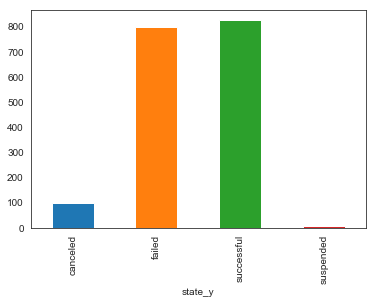

In [77]:
# We can see that outcomes are fairly well balanced, so no need for any rebalancing techniques

stateCount = consolidated_table.groupby('state_y')['id_x'].count()
stateCount.plot(kind='bar')

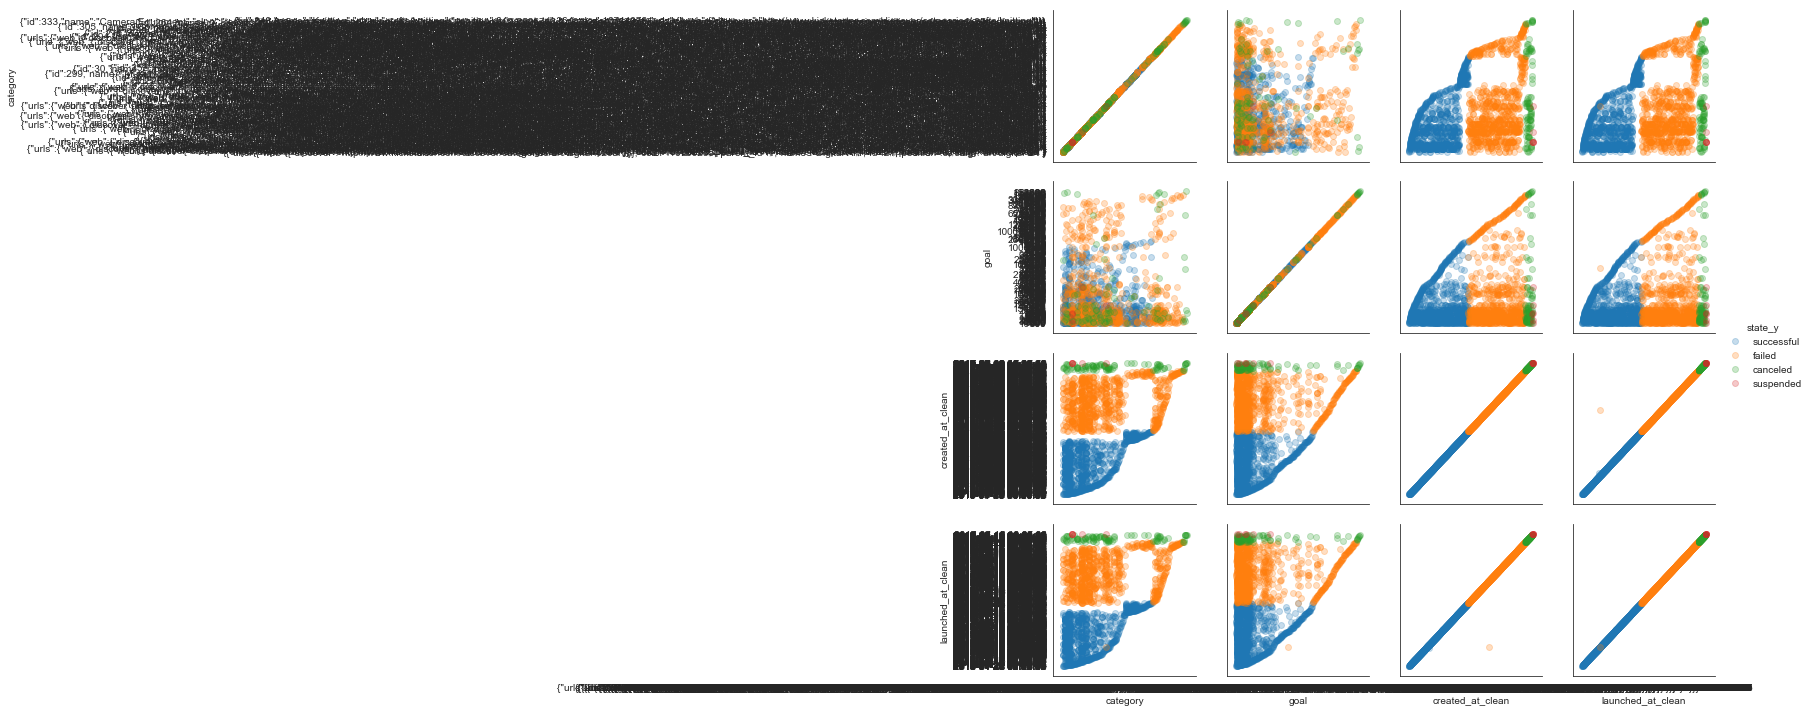

In [80]:

g = sns.PairGrid(consolidated_table, vars=['category','goal','created_at_clean','launched_at_clean'], hue='state_y')
#g.map_diag(plt.hist)
#g.map_offdiag(plt.scatter)
g.map(plt.scatter,alpha=0.25)
g.add_legend()

In [18]:
# For safe keeping
masterTable = consolidated_table.copy()


In [19]:
# I unpack the nested columns below, creating new features

# https://chrisalbon.com/python/data_wrangling/pandas_regex_to_create_columns/
# https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers  
# https://stackoverflow.com/questions/4260280/if-else-in-pythons-list-comprehension


import re
masterTable['creator_clean'] = [re.search('"name":"(.+?)"',x) for x in masterTable['creator']]
masterTable['creator_clean'] = [x.group(1) if x is not None else '' for x in masterTable['creator_clean']]



masterTable['category_clean'] = [re.search('"http://www.kickstarter.com/discover/categories/(.+?)"}}',x) for x in masterTable['category']]
masterTable['category_clean'] = [x.group(1) if x is not None else '' for x in masterTable['category_clean']]




masterTable['location_clean_country'] = [re.search('{"country":"(.+?)",',x) for x in masterTable['location']]
masterTable['location_clean_country'] = [x.group(1) if x is not None else '' for x in masterTable['location_clean_country']]



masterTable['location_clean_name'] = [re.search('}},"name":"(.+?)","displayable_name"',x) for x in masterTable['location']]
masterTable['location_clean_name'] = [x.group(1) if x is not None else '' for x in masterTable['location_clean_name']]


masterTable['location_clean_state'] = [re.search('"state":"(.+?)","type":',x) for x in masterTable['location']]
masterTable['location_clean_state'] = [x.group(1) if x is not None else '' for x in masterTable['location_clean_state']]



In [20]:
masterTable.columns

Index(['id_x', 'slug', 'name', 'blurb', 'creator', 'category', 'goal',
       'created_at_clean', 'launched_at_clean', 'deadline_clean', 'location',
       'scrape_date', 'state_x', 'id_y', 'state_y', 'state_changed_at_clean',
       'creator_clean', 'category_clean', 'location_clean_country',
       'location_clean_name', 'location_clean_state'],
      dtype='object')

In [21]:
masterTable_copy = masterTable.copy()

# Dropping the original columns used in creating the new features

masterTable = masterTable.drop(columns=['id_x','slug','category','creator','location'])

In [22]:
### Text Pre-Process

# https://radimrehurek.com/gensim/parsing/preprocessing.html
# https://medium.springboard.com/identifying-duplicate-questions-a-machine-learning-case-study-37117723844
# https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
# https://github.com/explosion/spaCy/issues/327
# https://nicschrading.com/project/Intro-to-NLP-with-spaCy/
# https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
# https://medium.com/@pemagrg/nlp-for-beninners-using-spacy-6161cf48a229
# https://nlpforhackers.io/complete-guide-to-spacy/



nlp = English()
stops = STOP_WORDS



def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


In [23]:
masterTable['blurb_clean'] = masterTable['blurb'].apply(normalize, lowercase=True, remove_stopwords=True)
masterTable['name_clean'] = masterTable['name'].apply(normalize, lowercase=True, remove_stopwords=True)

masterTable['combined'] = masterTable['blurb_clean'] + masterTable['name_clean'] + masterTable['category_clean']

In [24]:
masterTable.head(50)

,name,blurb,goal,created_at_clean,launched_at_clean,deadline_clean,scrape_date,state_x,id_y,state_y,state_changed_at_clean,creator_clean,category_clean,location_clean_country,location_clean_name,location_clean_state,blurb_clean,name_clean,combined
0,'Tangibility / Abstraction' exhibition,I'm currently working on funding a solo exhibi...,600,2016-01-28 10:59:30,2016-01-28 12:32:01,2016-03-18 11:32:01,2016-01-28,live,1.507480e+09,successful,2016-03-18 11:32:02,Petra Nicel,art/digital%20art,AU,Melbourne,VIC,-PRON- currently work fund solo exhibition abs...,' tangibility / abstraction ' exhibition,-PRON- currently work fund solo exhibition abs...
1,"Presidential Candidate Bobbleheads: Trump, Hil...",Most comprehensive selection of 2016 President...,10000,2016-01-24 21:13:05,2016-01-28 03:53:58,2016-03-01 01:00:00,2016-01-28,live,8.958270e+08,successful,2016-03-01 01:00:02,Phil Sklar,art/sculpture,US,Milwaukee,WI,comprehensive selection 2016 presidential camp...,"presidential candidate bobbleheads : trump , h...",comprehensive selection 2016 presidential camp...
2,FamiFlicks Flipbooks,FamiFlicks turns your videos into awesome flip...,500,2016-01-18 15:24:01,2016-01-28 01:29:49,2016-02-27 01:29:49,2016-01-28,live,4.499984e+08,successful,2016-02-27 01:29:50,Lou Paris,art/video%20art,US,Daytona Beach,FL,famiflicks turn video awesome flip book .,famiflicks flipbooks,famiflicks turn video awesome flip book .famif...
3,PROJECT FLINT,"Firestarter kits for revolutionaries! markers,...",63000,2016-01-22 04:34:34,2016-01-28 02:31:03,2016-02-12 02:31:03,2016-01-28,live,NaN,NaN,NaN,Volkmar Torben Neudoerffer,crafts/printing,US,San Francisco,CA,"firestarter kit revolutionary ! marker , stick...",project flint,"firestarter kit revolutionary ! marker , stick..."
4,"""Xpand Wallet"" Minimalist magic card holder.","""Xpand wallet"" The minimalist magic card holde...",6000,2015-09-18 03:37:32,2016-01-28 02:00:43,2016-03-03 02:00:43,2016-01-28,live,1.335681e+09,successful,2016-03-03 02:00:43,Leather Republic of Leon,design/interactive%20design,US,Denver,CO,""" xpand wallet "" minimalist magic card holder ...",""" xpand wallet "" minimalist magic card holder .",""" xpand wallet "" minimalist magic card holder ..."
5,ACU-PT,Post Tension Elongation Measuring Tool,115000,2016-01-14 06:35:57,2016-01-28 02:41:11,2016-03-28 01:41:11,2016-01-28,live,NaN,NaN,NaN,Thania Vargas,design/product%20design,US,Miami,FL,post tension elongation measure tool,acu - pt,post tension elongation measure toolacu - ptde...
6,Get the best from your laptop through this woo...,If until now you needed to buy 2 laptop stand ...,500,2016-01-26 06:58:24,2016-01-28 00:31:09,2016-02-11 00:31:09,2016-01-28,live,NaN,NaN,NaN,Alessio Rocchi,design/product%20design,IT,Florence,Tuscany,need buy 2 laptop stand perfect ergonomics use...,laptop wood laptop stand,need buy 2 laptop stand perfect ergonomics use...
7,"Bagsablaze - Lighting your bag, lighting your ...","A rechargeable light, fits onto most handbags ...",50000,2015-04-24 02:23:43,2016-01-28 08:37:39,2016-03-13 07:37:39,2016-01-28,live,NaN,NaN,NaN,Marcia Mattushek,design/product%20design,AU,Brisbane,QLD,"rechargeable light , fit handbag easy find ' s...","bagsablaze - light bag , light life !","rechargeable light , fit handbag easy find ' s..."
8,"""The Grid"" - the modular backpack for urban no...","KANCHA presents ""The Grid"": a sustainable and ...",50000,2015-12-08 17:42:15,2016-01-28 11:05:26,2016-03-01 11:00:00,2016-01-28,live,NaN,NaN,NaN,KANCHA Design,design/product%20design,DE,Berlin,Berlin,"kancha present "" grid "" : sustainable modular ...",""" grid "" - modular backpack urban nomad","kancha present "" grid "" : sustainable modular ..."
9,Bike Saddle Cover Keychain,"2,5 Billion people in the world ride bikes, an...",2000,2016-01-20 18:39:33,2016-01-28 07:25:09,2016-02-27 07:25:09,2016-01-28,live,8.796630e+08,successful,2016-02-27 07:25:09,Kikkerproducts,design/product%20design,NL,Rotterdam,South Holland,"2,5 billion people 

In [25]:
# Exploring the bag of words model, we see that there are potentially many more words than records, indicating 
# a potential concern with resulting sparsity when applied to our current train-test data set

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(masterTable.combined)
print(vectorizer.get_feature_names())

['00', '000', '003', '01', '0design', '0fashion', '10', '100', '1000', '1000games', '101', '10k', '10thstl', '11', '115', '119', '12', '120', '1200', '120sq', '121c', '124', '124film', '125', '128gbmemory', '129', '129technology', '12v', '13', '132', '1320', '136', '138usd', '13th', '14', '144bcd', '1453', '14th', '15', '150', '16', '1605', '16th', '17', '1717', '18', '1868', '1882publishing', '1892', '18x24', '19', '1921', '1931', '1937', '1940', '1941', '1944', '1964', '1966', '1980s', '1982', '1984', '1994', '1995', '1998', '1998gallery', '19th', '1comics', '1design', '1er', '1film', '1games', '1music', '1publishing', '1st', '1technology', '20', '200', '2001', '2002', '2011', '2012', '2014', '2015', '2016', '2016games', '2017', '2017art', '2017dance', '2017design', '2017film', '2017flea', '2017games', '2017tap', '2017want', '2017warp', '2018', '2018art', '2018crafts', '2018film', '2018help', '2019', '2019adam', '2045', '2050', '20adult', '20art', '20batch', '20books', '20cards', '20

In [26]:
# Similarly with TFIDF
# If scrolled all the way down, we'll also note the presence of non-English words as well

tfidf_vector = TfidfVectorizer()
tfid = tfidf_vector.fit_transform(masterTable.combined)
print(vectorizer.get_feature_names())

['00', '000', '003', '01', '0design', '0fashion', '10', '100', '1000', '1000games', '101', '10k', '10thstl', '11', '115', '119', '12', '120', '1200', '120sq', '121c', '124', '124film', '125', '128gbmemory', '129', '129technology', '12v', '13', '132', '1320', '136', '138usd', '13th', '14', '144bcd', '1453', '14th', '15', '150', '16', '1605', '16th', '17', '1717', '18', '1868', '1882publishing', '1892', '18x24', '19', '1921', '1931', '1937', '1940', '1941', '1944', '1964', '1966', '1980s', '1982', '1984', '1994', '1995', '1998', '1998gallery', '19th', '1comics', '1design', '1er', '1film', '1games', '1music', '1publishing', '1st', '1technology', '20', '200', '2001', '2002', '2011', '2012', '2014', '2015', '2016', '2016games', '2017', '2017art', '2017dance', '2017design', '2017film', '2017flea', '2017games', '2017tap', '2017want', '2017warp', '2018', '2018art', '2018crafts', '2018film', '2018help', '2019', '2019adam', '2045', '2050', '20adult', '20art', '20batch', '20books', '20cards', '20

In [27]:
masterTable.columns

Index(['name', 'blurb', 'goal', 'created_at_clean', 'launched_at_clean',
       'deadline_clean', 'scrape_date', 'state_x', 'id_y', 'state_y',
       'state_changed_at_clean', 'creator_clean', 'category_clean',
       'location_clean_country', 'location_clean_name', 'location_clean_state',
       'blurb_clean', 'name_clean', 'combined'],
      dtype='object')

In [28]:
masterTable['outcome'] = [1 if x =='successful' else 0 for x in masterTable['state_y']]
masterTable = masterTable.drop(['id_y','name', 'blurb', 'state_x','state_y', 'scrape_date','state_changed_at_clean','blurb_clean','name_clean'],axis=1)


In [29]:
masterTable.dtypes

goal                      object
created_at_clean          object
launched_at_clean         object
deadline_clean            object
creator_clean             object
category_clean            object
location_clean_country    object
location_clean_name       object
location_clean_state      object
combined                  object
outcome                    int64
dtype: object

In [30]:
masterTable = masterTable.astype({'goal':int})
masterTable.dtypes

goal                       int32
created_at_clean          object
launched_at_clean         object
deadline_clean            object
creator_clean             object
category_clean            object
location_clean_country    object
location_clean_name       object
location_clean_state      object
combined                  object
outcome                    int64
dtype: object

In [31]:
masterTable['launched'] = pd.to_datetime(masterTable['launched_at_clean'])
masterTable['created'] = pd.to_datetime(masterTable['created_at_clean'])
masterTable['deadline'] = pd.to_datetime(masterTable['deadline_clean'])

masterTable = masterTable.drop(['launched_at_clean','created_at_clean','deadline_clean'],axis=1)

masterTable['time_to_launch'] = (masterTable['launched'] - masterTable['created']).dt.days
masterTable['launch_to_deadline'] = (masterTable['deadline'] - masterTable['launched']).dt.days

masterTable['launched_month'] = masterTable.launched.dt.month
masterTable['launched_year'] = masterTable.launched.dt.year

masterTable['created_month'] = masterTable.created.dt.month
masterTable['created_year'] = masterTable.created.dt.year


masterTable['deadline_month'] = masterTable.deadline.dt.month
masterTable['deadline_year'] = masterTable.deadline.dt.year

masterTable = masterTable.drop(['launched','created','deadline'],axis=1)

In [32]:
masterTable.dtypes

goal                       int32
creator_clean             object
category_clean            object
location_clean_country    object
location_clean_name       object
location_clean_state      object
combined                  object
outcome                    int64
time_to_launch             int64
launch_to_deadline         int64
launched_month             int64
launched_year              int64
created_month              int64
created_year               int64
deadline_month             int64
deadline_year              int64
dtype: object

In [33]:
# Goal of FunctionTransformer: takes a Python job and turn it into an object that the scikit-learn Pipeline can understand
# Write 3 functions for pipeline preprocessing
# 1) Takes entire DataFrame and returns numeric columns
# 2) Takes entire DataFrame and returns text columns
# 3) Takes entire DataFrame and returns categorical columns
# Using these function transformer objects, we can build a separate Pipeline for our numeric data, text data, and categorical data

#Parameter: validate = False => tells scikit-learn it doesn't need to check for NaNs or va;idate the dtypes of the input


get_text_data = FunctionTransformer(lambda x: x['combined'], validate = False) 

get_numeric_data = FunctionTransformer(lambda x: x[['goal','time_to_launch', 'launch_to_deadline', 'launched_month','launched_year', 'created_month', 'created_year', 'deadline_month','deadline_year']], validate = False)

# Took out creator_clean
get_categorical_data = FunctionTransformer(lambda x: x[['category_clean', 'location_clean_country','location_clean_name', 'location_clean_state']], validate = False)

### Model Variant 1: Logistic Regression with Bag of Words

The first model variant we'll try is a Logistic Regression model using Bag of Words to add additional features, which is reflected in the text_pipeline, using CountVectorizer() from sklearn.

In order to account for features that could be in the test but not train data set we set the handle_unknown parameter of OneHotEncoder to 'ignore'. 

For imputation I chose not to fill in values as certain features like time_to_launch had high variance, with some campaigns launching within 1 day and others taking months at a time. 

Although we wouldn't expect this first model variant to perform extremely well given that we're only using Bag of Words, we can still establish the base level of signal that could be extracted before using additional advanced NLP techniques amd hyperparameter tuning.

In [34]:
#get_numeric_data created in prior block as FunctionTransformers
numeric_pipeline = Pipeline([('selector', get_numeric_data),
                             ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value =0))
                            ])

text_pipeline = Pipeline([('selector',get_text_data),
                         ('vectorizer',CountVectorizer())])

categorical_pipeline = Pipeline([('selector',get_categorical_data),
                                 ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='No Value')),
                                ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# handle_unknown: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
# https://github.com/scikit-learn/scikit-learn/issues/12494

pl = Pipeline([
    ('union',FeatureUnion([
        ('numeric', numeric_pipeline),
        ('text',text_pipeline),
        ('categorical',categorical_pipeline)
    ])),
    ('logreg',LogisticRegression())
])

y = masterTable['outcome']
X = masterTable.drop(['outcome','creator_clean'], axis = 1)


# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=42)




pl.fit(Xlr, ylr)

accuracy = pl.score(Xtestlr, ytestlr)

print(accuracy)

0.6548042704626335


Using minimal feature engineering and a simple logistic regression model lends an accuracy of 65%, which we'll find to be only slightly less than the best performing model. 

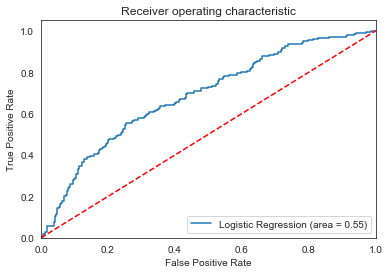

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, pl.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, pl.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Model Variant 2: Linear SVC with Bag of Words

In [35]:
#get_numeric_data created in prior block as FunctionTransformers
numeric_pipeline = Pipeline([('selector', get_numeric_data),
                             ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value =0))
                            ])

text_pipeline = Pipeline([('selector',get_text_data),
                         ('vectorizer',CountVectorizer())])

categorical_pipeline = Pipeline([('selector',get_categorical_data),
                                 ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='No Value')),
                                ('onehot',OneHotEncoder(handle_unknown='ignore'))])
# handle_unknown: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
# https://github.com/scikit-learn/scikit-learn/issues/12494



pl_lvc = Pipeline([
    ('union',FeatureUnion([
        ('numeric', numeric_pipeline),
        ('text',text_pipeline),
        ('categorical',categorical_pipeline)
    ])),
    ('lvc',LinearSVC())
])


### Need to solve issue where some categories aren't showing up because of train test split

y_lvc = masterTable['outcome']
X_lvc = masterTable.drop(['outcome','creator_clean'], axis = 1)


# Split the data into a training and test set.
Xlvc, Xtestlvc, ylvc, ytestlvc = train_test_split(X_lvc,y_lvc,random_state=42)




pl_lvc.fit(Xlvc, ylvc)

accuracy_lvc = pl_lvc.score(Xtestlvc, ytestlvc)

print(accuracy_lvc)

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6405693950177936


### Model Variant 3: Logistic Regression with Bag of Words & TFIDF

The second model variant we'll try is a Linear SVC, whcih supports both dense and sparse matrices. 

The advtange of using an SVM type model is they're efficacy in high dimensional spaces, even case where the number of dimensions is much greater than the number of samples. When applying Bag of Words, n-grams,etc especially in this current project, the resulting matrix is incredibly sparese.

We also then feed the Bag of Words resulting matrix into a TfidfTransformer, which will create a normalized Tfidf representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [36]:
#get_numeric_data created in prior block as FunctionTransformers


numeric_pipeline = Pipeline([('selector', get_numeric_data),
                             ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value =0))
                            ])

text_pipeline = Pipeline([('selector',get_text_data),
                         ('vectorizer',CountVectorizer()),
                         ('tfidf', TfidfTransformer())])

categorical_pipeline = Pipeline([('selector',get_categorical_data),
                                 ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='No Value')),
                                ('onehot',OneHotEncoder(handle_unknown='ignore'))])
# handle_unknown: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
# https://github.com/scikit-learn/scikit-learn/issues/12494



pl_lr3 = Pipeline([
    ('union',FeatureUnion([
        ('numeric', numeric_pipeline),
        ('text',text_pipeline),
        ('categorical',categorical_pipeline)
    ])),
('logreg',LogisticRegression())])


### Need to solve issue where some categories aren't showing up because of train test split

y_lr2 = masterTable['outcome']
X_lr2 = masterTable.drop(['outcome','creator_clean'], axis = 1)


# Split the data into a training and test set.
Xlr2, Xtestlr2, ylr2, ytestlr2 = train_test_split(X_lr2,y_lr2,random_state=42)




pl_lr3.fit(Xlr2, ylr2)

accuracy_lr2 = pl_lr3.score(Xtestlr2, ytestlr2)

print(accuracy_lr2)

0.6565836298932385


The accuracy is disappointingly comparable to our first variation and potentially indicates that we may not have the volume of data or number of attributes needed in order to make robust predictions.

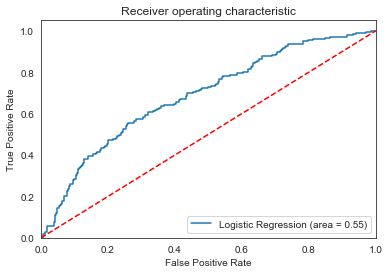

In [55]:
logit_roc_auc = roc_auc_score(ytestlr2, pl_lr3.predict(Xtestlr2))
fpr, tpr, thresholds = roc_curve(ytestlr2, pl_lr3.predict_proba(Xtestlr2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Model Variant 4: Random Forest Classifier with Bi-grams & TFIDF

In our fourth variant I switch Bag of Words out for bi-grams and use a Random Forest model instead of a Linear SVC. Random Forest models can also be quite robust in handling wide tables and sparse matrices. 

Given the similarity in performance I then try to see how much additional lift can be produced through hyperparameter tuning. While tuning using RandomizedGridSearchCV and GridSearchCV adds an additional ~2-3%, it seems the best accuracy we can accomplish using basic NLP techniques is about 67%. 

In [37]:
#get_numeric_data created in prior block as FunctionTransformers


numeric_pipeline = Pipeline([('selector', get_numeric_data),
                             ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value =0))
                            ])

text_pipeline = Pipeline([('selector',get_text_data),
                         ('vectorizer',CountVectorizer(ngram_range=(2,2))),
                         ('tfidf', TfidfTransformer())])
# https://www.quora.com/What-is-the-difference-between-tfidfVectorizer-and-TfidfTransformer-And-what-about-their-output

categorical_pipeline = Pipeline([('selector',get_categorical_data),
                                 ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='No Value')),
                                ('onehot',OneHotEncoder(handle_unknown='ignore'))])
# handle_unknown: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
# https://github.com/scikit-learn/scikit-learn/issues/12494



pl_rf = Pipeline([
    ('union',FeatureUnion([
        ('numeric', numeric_pipeline),
        ('text',text_pipeline),
        ('categorical',categorical_pipeline)
    ])),
('randomforest',RandomForestClassifier())])


### Need to solve issue where some categories aren't showing up because of train test split

y_rf = masterTable['outcome']
X_rf = masterTable.drop(['outcome','creator_clean'], axis = 1)


# Split the data into a training and test set.
Xrf, Xtestrf, yrf, ytestrf = train_test_split(X_rf,y_rf,random_state=42)




pl_rf.fit(Xrf, yrf)

accuracy_rf = pl_rf.score(Xtestrf, ytestrf)

print(accuracy_rf)

print(cross_val_score(estimator=pl_rf, X=Xrf, y=yrf, cv = 5))

# Using Randomized search cv: https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
# Using randomized search cv: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py
# Computing Feature Importance with OneHotEncoded Features:  https://stackoverflow.com/questions/39043326/computing-feature-importance-with-onehotencoded-features 

0.6565836298932385
[0.64497041 0.63501484 0.64391691 0.64391691 0.64285714]


In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'randomforest__n_estimators': n_estimators,
               'randomforest__max_features': max_features,
               'randomforest__max_depth': max_depth,
               'randomforest__min_samples_split': min_samples_split,
               'randomforest__min_samples_leaf': min_samples_leaf,
               'randomforest__bootstrap': bootstrap,}


# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = pl_rf, param_distributions = random_grid, cv = 5)
# Fit the random search model
rf_random.fit(Xrf, yrf)

rf_random.best_params_

{'randomforest__n_estimators': 2000,
 'randomforest__min_samples_split': 2,
 'randomforest__min_samples_leaf': 2,
 'randomforest__max_features': 'sqrt',
 'randomforest__max_depth': 60,
 'randomforest__bootstrap': False}

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 950, stop = 1050, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(90, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]






search_grid = {'randomforest__n_estimators': n_estimators,
               'randomforest__max_features': max_features,
               'randomforest__max_depth': max_depth,
               'randomforest__min_samples_split': min_samples_split,
               'randomforest__min_samples_leaf': min_samples_leaf,
               'randomforest__bootstrap': bootstrap,}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = pl_rf, param_grid = search_grid, cv = 5,)

# Fit the grid search to the data
grid_search.fit(Xrf, yrf)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x0000015E9CAF67B8>, inv_kw_args=None,
          inverse_func=None, kw_args...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforest__n_estimators': [950, 961, 972, 983, 994, 1005, 1016, 1027, 1038, 1050], 'randomforest__max_features': ['auto', 'sqrt'], 'randomforest__max_depth': [90, 95, 100, 105, 110, None], 'randomforest__min_samples_split': [2, 3], 'randomforest__min_samples_leaf': [1, 2], 'randomforest__bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print("Best parameter:",grid_search.best_params_)
print("Best score:",grid_search.best_score_)
print("Test set accuracy:",accuracy_score(ytestrf,grid_search.predict(Xtestrf)))

Best parameter: {'randomforest__bootstrap': False, 'randomforest__max_depth': 90, 'randomforest__max_features': 'auto', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 2, 'randomforest__n_estimators': 950}
Best score: 0.6807121661721068
Test set accuracy: 0.6743772241992882
